# 用训练得到的模型预测-单张图片

同济子豪兄 2023-2-15 6-11 6-25

## 进入MMSegmentation主目录

In [1]:
import os
os.chdir('mmsegmentation')

In [2]:
os.getcwd()

'/home/featurize/work/MMSegmentation教程20230625/mmsegmentation'

## 导入工具包

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

## 载入配置文件

In [4]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('Zihao-Configs/ZihaoDataset_KNet_20230712.py')

## 载入模型

In [5]:
# checkpoint_path = './work_dirs/ZihaoDataset-PSPNet/iter_40000.pth'

# checkpoint_path = 'checkpoint/Zihao_PSPNet.pth'

checkpoint_path = 'checkpoint/Zihao_KNet.pth'

# checkpoint_path = 'checkpoint/Zihao_Segformer.pth'

In [ ]:
model = init_model(cfg, checkpoint_path, 'cuda:0')

/home/featurize/work/MMSegmentation教程20230625/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/featurize/work/MMSegmentation教程20230625/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


Loads checkpoint by local backend from path: checkpoint/Zihao_KNet.pth


## 载入测试集图像，或新图像

In [ ]:
img_path = 'Watermelon87_Semantic_Seg_Mask/img_dir/val/01bd15599c606aa801201794e1fa30.jpg'

# img_path = 'Watermelon87_Semantic_Seg_Mask/img_dir/val/la_wm_img01.jpg'

# img_path = 'data/watermelon_test1.jpg'

In [ ]:
img_bgr = cv2.imread(img_path)

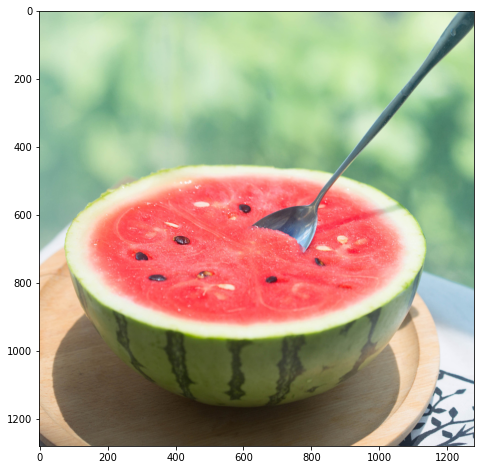

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 语义分割预测

In [ ]:
result = inference_model(model, img_bgr)

In [ ]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [ ]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [ ]:
pred_mask.shape

(1280, 1280)

In [ ]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4, 5])

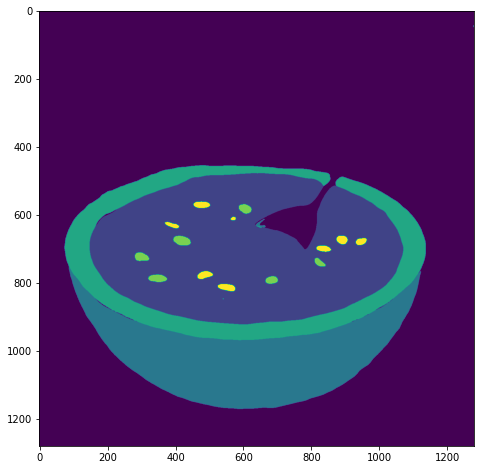

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_mask)
plt.savefig('outputs/K1-0.jpg')
plt.show()

## 可视化语义分割预测结果-方法一

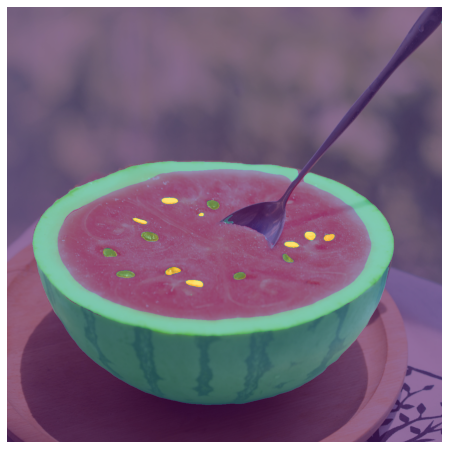

In [32]:
# 显示语义分割结果
plt.figure(figsize=(10, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.55) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.savefig('outputs/K1-1.jpg')
plt.show()

## 可视化语义分割预测结果-方法二（和原图并排显示）

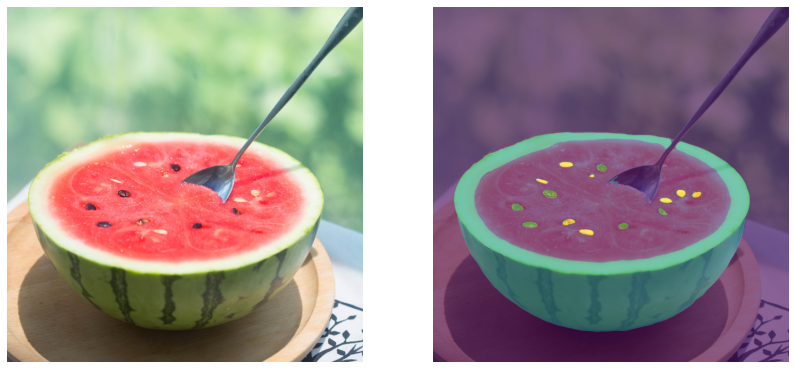

In [34]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.imshow(img_bgr[:,:,::-1])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.6) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.savefig('outputs/K1-2.jpg')
plt.show()

## 可视化语义分割预测结果-方法三（按配色方案叠加在原图上显示）

In [17]:
# 各类别的配色方案（BGR）
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [18]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

In [19]:
opacity = 0.3 # 透明度，越大越接近原图

In [20]:
# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)

cv2.imwrite('outputs/K1-3.jpg', pred_viz)

True

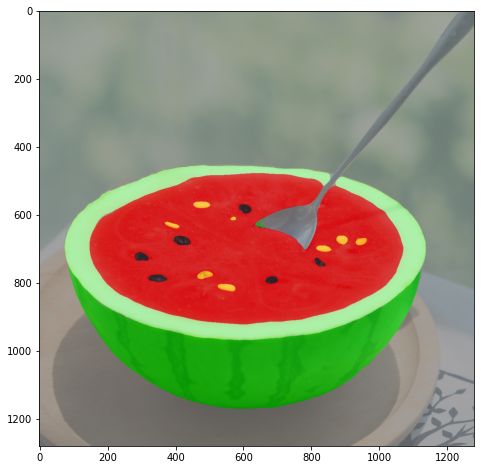

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_viz[:,:,::-1])
plt.show()

## 可视化语义分割预测结果-方法三

按照`mmseg/datasets/ZihaoDataset.py`里定义的类别颜色可视化

In [38]:
from mmseg.apis import show_result_pyplot

In [39]:
img_viz = show_result_pyplot(model, img_path, result, opacity=0.8, title='MMSeg', out_file='outputs/K1-4.jpg')

07/12 11:54:55 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


opacity控制透明度，越小，越接近原图。

In [40]:
img_viz.shape

(1280, 1280, 3)

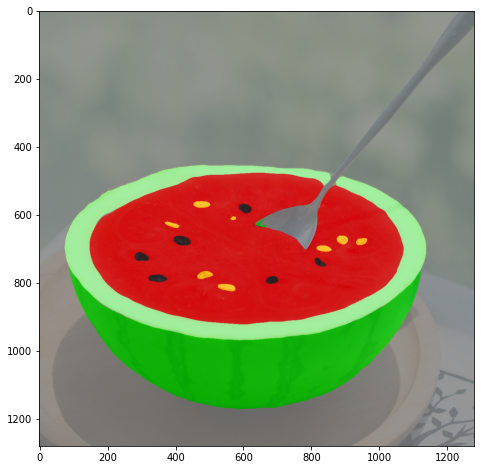

In [41]:
plt.figure(figsize=(14, 8))
plt.imshow(img_viz)
plt.show()

## 可视化语义分割预测结果-方法四（加图例）

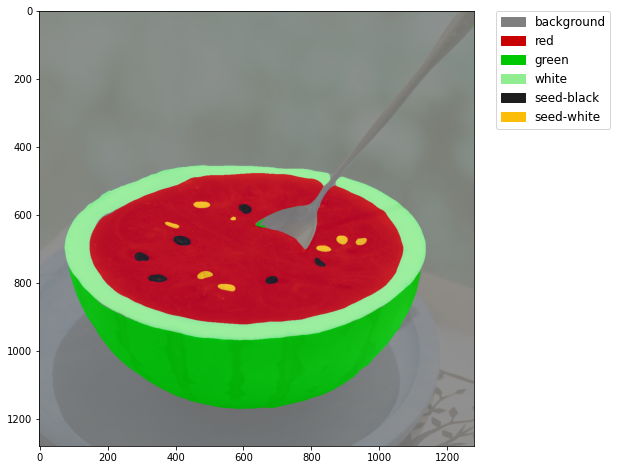

In [42]:
from mmseg.datasets import ZihaoDataset
import numpy as np
import mmcv 
from PIL import Image

# 获取类别名和调色板
classes = ZihaoDataset.METAINFO['classes']
palette = ZihaoDataset.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
# seg_map = result[0].astype('uint8')
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
img_plot = ((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255
im = plt.imshow(img_plot)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.savefig('outputs/K1-6.jpg')
plt.show()

## 获取测试集标注

In [28]:
label_path = 'Watermelon87_Semantic_Seg_Mask/ann_dir/val/01bd15599c606aa801201794e1fa30.png'

# label_path = 'Watermelon87_Semantic_Seg_Mask/ann_dir/val/la_wm_img01.png'

In [29]:
label = cv2.imread(label_path)

In [30]:
label.shape

(1280, 1280, 3)

三个通道全部一样，只取一个通道作为标注即可。

In [31]:
label_mask = label[:,:,0]

In [32]:
label_mask.shape

(1280, 1280)

In [33]:
np.unique(label_mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

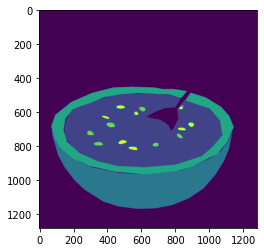

In [34]:
plt.imshow(label_mask)
plt.show()

## 对比测试集标注和语义分割预测结果

In [35]:
# 测试集标注
label_mask.shape

(1280, 1280)

In [36]:
# 语义分割预测结果
pred_mask.shape

(1280, 1280)

In [37]:
classes

['background', 'red', 'green', 'white', 'seed-black', 'seed-white']

In [38]:
# 真实为 西瓜红瓤，预测为 西瓜红壤
TP = (label_mask == 1) & (pred_mask==1)

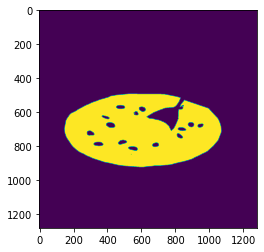

In [39]:
plt.imshow(TP)
plt.show()

## 绘制混淆矩阵

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [42]:
confusion_matrix_model

array([[1054799,    1571,    2248,    4055,       0,       0],
       [    889,  285214,      56,    5264,     365,     751],
       [   1735,       0,  160876,    3504,       0,       0],
       [   2128,    6592,     130,   98073,       0,       0],
       [      0,     227,       0,       0,    4692,       0],
       [     14,    1035,       0,       0,       0,    4182]])

In [43]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('outputs/K1-混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

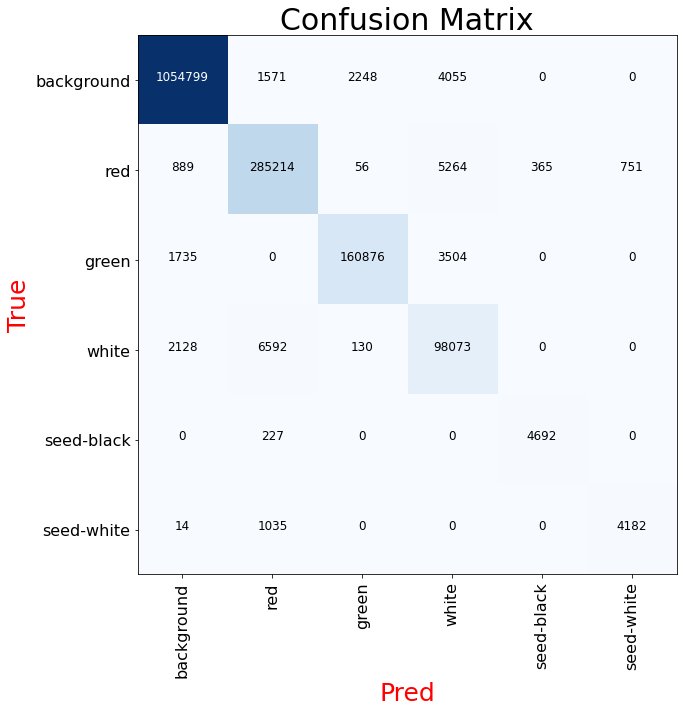

In [44]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')